Running Modular Reduction Scheme (Wainwright)...
Running Standard Diffusion (Baseline)...


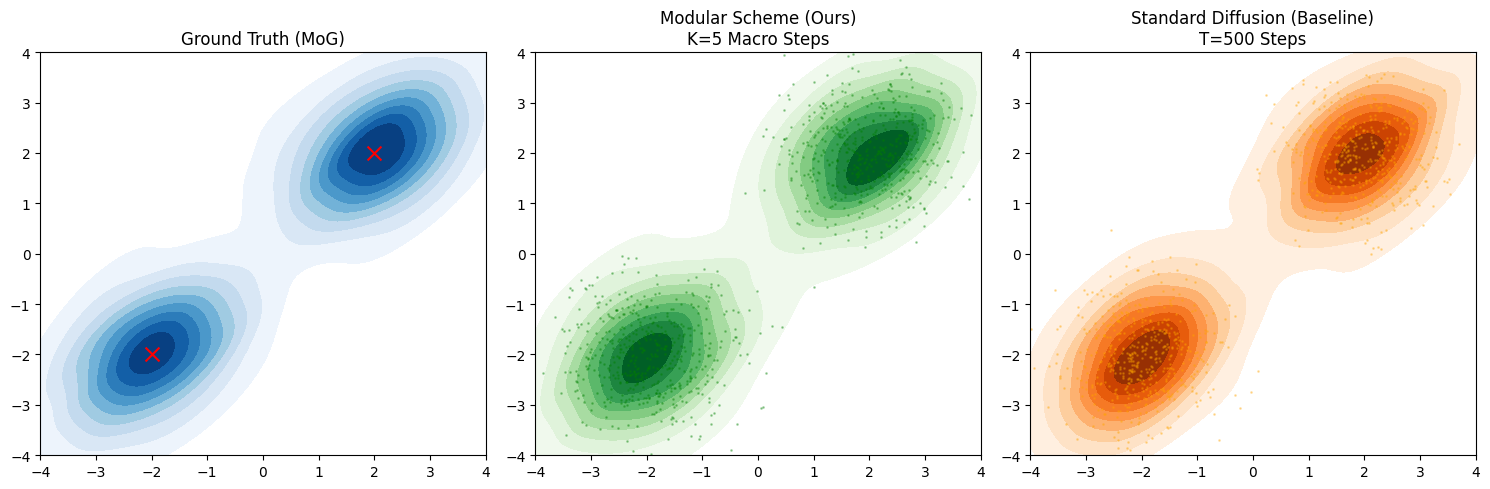

Mode Reconstruction Error - Modular: 0.0438
Mode Reconstruction Error - Diffusion: 0.0496


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

np.random.seed(13)


# --- 1. Target Distribution & Exact Score Setup ---
class GaussianMixture:
    """
    Represents a Mixture of Gaussians.
    Allows exact calculation of marginal scores for annealed distributions.
    """

    def __init__(self, means, covs, weights):
        self.means = np.array(means)
        self.covs = np.array(covs)
        self.weights = np.array(weights) / np.sum(weights)
        self.n_components = len(weights)
        self.dim = self.means.shape[1]

    def get_marginal_score(self, x, alpha_cum, sigma_sq_cum):
        """
        Calculates \nabla_x log p_t(x) for the annealed distribution.
        At step t: Y = sqrt(alpha_cum) * X0 + sqrt(sigma_sq_cum) * Z
        This is equivalent to convolving p0 with N(0, sigma_sq_cum/alpha_cum I)
        and scaling means by sqrt(alpha_cum).
        """
        # Adjust means and covariances for the noise level
        # For Y = aX + bW, mean -> a*mu, cov -> a^2*Sigma + b^2*I
        # Here we use standard diffusion notation equivalency for easier math:
        # scale = a (signal scale), noise_var = b^2

        scale = np.sqrt(alpha_cum)
        noise_var = sigma_sq_cum

        current_means = scale * self.means
        # Current covs: scale^2 * original_cov + noise_var * I
        current_covs = (scale**2) * self.covs + noise_var * np.eye(self.dim)[None, :, :]

        # Calculate log-likelihoods and gradients per component
        # We do this in log-space for numerical stability
        log_probs = []
        grads = []

        # Inefficient but clear loop for 2D
        for i in range(self.n_components):
            diff = x - current_means[i]
            inv_cov = np.linalg.inv(current_covs[i])
            exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            norm_const = -0.5 * (
                self.dim * np.log(2 * np.pi) + np.linalg.slogdet(current_covs[i])[1]
            )
            log_prob = exponent + norm_const
            log_probs.append(log_prob)

            grad = -(diff @ inv_cov)
            grads.append(grad)

        log_probs = np.array(log_probs)  # shape (n_comp, n_samples)
        grads = np.array(grads)  # shape (n_comp, n_samples, dim)

        # Softmax to get component responsibilities
        # w_i * p_i(x) / sum(w_j * p_j(x))
        # Compute using log-sum-exp trick
        weighted_log_probs = log_probs + np.log(self.weights)[:, None]
        max_log_probs = np.max(weighted_log_probs, axis=0)
        denom = max_log_probs + np.log(
            np.sum(np.exp(weighted_log_probs - max_log_probs), axis=0)
        )
        responsibilities = np.exp(
            weighted_log_probs - denom
        )  # shape (n_comp, n_samples)

        # Score is sum(resp_i * grad_i)
        score = np.sum(responsibilities[:, :, None] * grads, axis=0)
        return score


# Define Target: A simple 2-mode Gaussian
target_mog = GaussianMixture(
    means=[[-2, -2], [2, 2]],
    covs=[[[0.5, 0], [0, 0.5]], [[0.5, 0], [0, 0.5]]],
    weights=[0.5, 0.5],
)


# --- 2. The Modular Reduction Scheme ---
def modular_sampling_scheme(target_model, n_samples=1000):
    """
    Implementation of the Modular Reduction Scheme (Sequence of SLC problems).
    1. Define short trajectory K.
    2. Sample from terminal distribution p_K (approximated as Gaussian here).
    3. Iterate backwards: Sample p_{k|k+1}(y_k | y_{k+1}) using ULA.
    """
    # Trajectory settings
    K = 5
    # We define the forward process via 'Signal Retention' (alpha_bar).
    # alpha_bar = 1.0 (Pure Data) -> alpha_bar approaches 0.0 (Pure Noise)
    alpha_bars = np.linspace(1.0, 0.1, K + 1)

    # Start at terminal distribution (Noise)
    # In the paper, Y_K has marginal p_K. We approximate p_K as N(0, I)
    # since alpha_bar_K is small (0.1).
    y_curr = np.random.randn(n_samples, 2) * 1.5

    path_history = [y_curr.copy()]

    # Backward Loop: K-1 down to 0
    for k in range(K - 1, -1, -1):
        # Determine parameters for the transition Y_{k+1} = a_k Y_k + b_k W
        # We derive the step size 'a' from the ratio of cumulative signals
        current_signal = alpha_bars[k]
        next_signal = alpha_bars[k + 1]  # effectively 'previous' in forward time

        # a_k is essentially the ratio of signal scales between steps
        if k == 0:
            # Final step back to pure data (signal 1.0)
            a = 1.0 / next_signal  # Simplification for the final denoising
        else:
            a = next_signal / current_signal

        # For the demo, we ensure 'a' stays in a stable range (e.g., ~0.8)
        # to match the paper's "large step" philosophy.
        a = 0.8  # Fixed step size for demo simplicity, similar to paper's ~0.8 avg
        b = np.sqrt(1 - a**2)

        # Current Marginal Noise Stats for Y_k (target of this step)
        # We need the marginal score of Y_k.
        # For Y_k, the "total" signal alpha is alpha_bars[k].
        # Total noise variance roughly 1 - alpha_bars[k]^2.
        curr_alpha_cum = alpha_bars[k] ** 2
        curr_sigma_cum = 1 - curr_alpha_cum

        # ULA (Unadjusted Langevin Algorithm) Parameters
        # The paper says we solve a "SLC sampling problem".
        # We run ULA for N_sub steps to converge to p(y_k | y_{k+1})

        step_size_langevin = 0.05
        n_substeps = 50  # Number of inner loop steps (solving the sub-problem)

        # Initialize chain for y_k at y_{k+1} (warm start)
        y_next = y_curr.copy()

        for _ in range(n_substeps):
            z = np.random.randn(n_samples, 2)

            # 1. Compute Marginal Score of Y_k at current points
            score_marginal = target_mog.get_marginal_score(
                y_next, curr_alpha_cum, curr_sigma_cum
            )

            # 2. Compute Conditional Score (Eq 6)
            # grad_y_k log p(y_k | y_{k+1})
            # = score_marginal(y_k) + (a/b^2) * (y_{k+1} - a * y_k) ?
            # Check Eq 6: grad_u log p(u|v) = grad_u log p_u(u) - (a/b^2)(au - v)
            # Yes.

            likelihood_score = (
                (1 / b**2) * (y_curr - a * y_next) * a
            )  # Gradient of gaussian transition
            # Note: The paper has -(a/b^2)(au - v).
            # The likelihood term is -1/(2b^2) ||v - au||^2. Gradient wrt u is:
            # -1/(2b^2) * 2 * (v - au) * (-a) = (a/b^2)(v - au).
            # Matches.

            total_score = score_marginal + likelihood_score

            # ULA Update: x' = x + step * score + sqrt(2*step) * z
            y_next = (
                y_next
                + step_size_langevin * total_score
                + np.sqrt(2 * step_size_langevin) * z
            )

        y_curr = y_next
        path_history.append(y_curr.copy())

    return y_curr, path_history


# --- 3. Standard Diffusion Baseline ---
def standard_diffusion_sampler(target_model, n_samples=1000, n_steps=500):
    """
    Standard DDPM-style Ancestral Sampling / Euler-Maruyama.
    Many small steps.
    """
    # Standard linear beta schedule
    betas = np.linspace(0.0001, 0.02, n_steps)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas)

    # Start from Noise
    x = np.random.randn(n_samples, 2)

    for t in range(n_steps - 1, -1, -1):
        z = np.random.randn(n_samples, 2) if t > 0 else 0

        # Variables for Score calc
        # In DDPM notation: alpha_bar_t is signal variance factor
        # Our get_marginal_score takes (signal_sq, noise_sq)
        # DDPM: x_t = sqrt(alpha_bar)*x_0 + sqrt(1-alpha_bar)*eps
        alpha_bar = alphas_cumprod[t]

        # Calculate Score
        score = target_model.get_marginal_score(x, alpha_bar, 1 - alpha_bar)

        # Reverse SDE update (Euler-Maruyama)
        # dx = [f(x,t) - g^2 score] dt + g dw
        # Simple Ancestral sampling formula:
        # x_{t-1} = 1/sqrt(alpha) * (x_t - (1-alpha)/sqrt(1-alpha_bar) * eps) + sigma*z
        # We can map score to eps: eps = -sigma_t * score
        sigma_t = np.sqrt(1 - alpha_bar)
        eps_pred = -sigma_t * score

        beta_t = betas[t]
        alpha_t = alphas[t]

        mean = (1 / np.sqrt(alpha_t)) * (
            x - (beta_t / np.sqrt(1 - alpha_bar)) * eps_pred
        )
        sigma_step = np.sqrt(beta_t)

        x = mean + sigma_step * z

    return x


# --- 4. Experiment & Visualization ---
# Run Modular Reduction Scheme
print("Running Modular Reduction Scheme (Wainwright)...")
# Note: K=5 macro steps, 50 sub-steps each = 250 total evaluations approx
samples_modular, history_modular = modular_sampling_scheme(target_mog)

# Run Standard Diffusion
print("Running Standard Diffusion (Baseline)...")
# 500 steps linear schedule
samples_diffusion = standard_diffusion_sampler(target_mog, n_steps=500)

# Plotting
plt.figure(figsize=(15, 5))

# Ground Truth
plt.subplot(1, 3, 1)
ground_truth = np.concatenate(
    [
        np.random.multivariate_normal(m, c, 500)
        for m, c in zip(target_mog.means, target_mog.covs)
    ]
)
sns.kdeplot(
    x=ground_truth[:, 0], y=ground_truth[:, 1], fill=True, cmap="Blues", levels=10
)
plt.scatter(target_mog.means[:, 0], target_mog.means[:, 1], c="red", marker="x", s=100)
plt.title("Ground Truth (MoG)")
plt.xlim(-4, 4)
plt.ylim(-4, 4)

# Modular Reduction Scheme
plt.subplot(1, 3, 2)
sns.kdeplot(
    x=samples_modular[:, 0],
    y=samples_modular[:, 1],
    fill=True,
    cmap="Greens",
    levels=10,
)
plt.scatter(samples_modular[:, 0], samples_modular[:, 1], s=1, alpha=0.3, c="green")
plt.title("Modular Scheme (Ours)\nK=5 Macro Steps")
plt.xlim(-4, 4)
plt.ylim(-4, 4)

# Standard Diffusion
plt.subplot(1, 3, 3)
sns.kdeplot(
    x=samples_diffusion[:, 0],
    y=samples_diffusion[:, 1],
    fill=True,
    cmap="Oranges",
    levels=10,
)
plt.scatter(
    samples_diffusion[:, 0], samples_diffusion[:, 1], s=1, alpha=0.3, c="orange"
)
plt.title("Standard Diffusion (Baseline)\nT=500 Steps")
plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.tight_layout()
plt.show()


# Quantitative Check (Distance of means)
def get_mode_error(samples, true_means):
    # Cluster samples to nearest mean and check distance
    # Simple check for 2-mode separation
    mode_1_samples = samples[samples[:, 0] < 0]
    mode_2_samples = samples[samples[:, 0] > 0]

    if len(mode_1_samples) == 0 or len(mode_2_samples) == 0:
        return np.inf  # Failed to cover modes

    est_mean_1 = np.mean(mode_1_samples, axis=0)
    est_mean_2 = np.mean(mode_2_samples, axis=0)

    err_1 = np.linalg.norm(est_mean_1 - true_means[0])
    err_2 = np.linalg.norm(est_mean_2 - true_means[1])
    return (err_1 + err_2) / 2


err_modular = get_mode_error(samples_modular, target_mog.means)
err_diffusion = get_mode_error(samples_diffusion, target_mog.means)

print(f"Mode Reconstruction Error - Modular: {err_modular:.4f}")
print(f"Mode Reconstruction Error - Diffusion: {err_diffusion:.4f}")